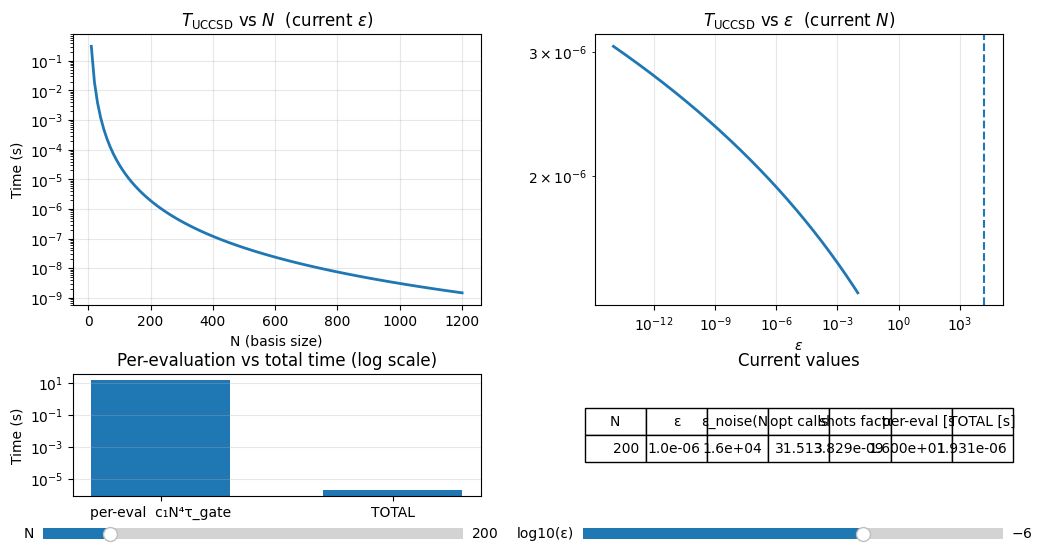

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# ------------------ Constants (VQE – UCCSD) ------------------
alpha_opt = 1.0
beta_opt  = 20.0
sigma2    = 1.0
c1        = 1e-2
tau_gate  = 1e-6
p_gate    = 1e-3
T2        = 0.1
E0        = 1e-1

# ------------------ Helpers ------------------
def D(N):
    # circuit depth proxy
    return c1 * N**4

def eps_noise(N):
    # ε_noise = p_gate*D + D * (tau_gate/T2)
    return D(N) * (p_gate + tau_gate / T2)

def opt_calls(eps):
    # vectorized
    return np.maximum(0.0, alpha_opt * np.log(E0 / eps)) + beta_opt

def shots_factor(N, eps):
    # σ^2 / (ε - ε_noise)^2 , clipped to avoid division by 0
    denom = np.maximum(1e-30, np.abs(eps - eps_noise(N)))
    return sigma2 / (denom**2)

def per_eval_time(N):
    # time for one circuit evaluation: (c1 N^4 τ_gate)
    return D(N) * tau_gate

def T_total(N, eps):
    # T = [opt_calls] * [shots_factor] * [per_eval_time]
    return opt_calls(eps) * shots_factor(N, eps) * per_eval_time(N)

# ------------------ Figure layout ------------------
plt.close("all")
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[4, 1.8], wspace=0.28, hspace=0.35)

axN   = fig.add_subplot(gs[0, 0])   # T vs N
axE   = fig.add_subplot(gs[0, 1])   # T vs eps
axBar = fig.add_subplot(gs[1, 0])   # bars
axTbl = fig.add_subplot(gs[1, 1])   # table

# ------------------ Defaults ------------------
N0 = 200
logeps0 = -6.0
eps0 = 10**logeps0

# ------------------ Left: T vs N ------------------
Nmin, Nmax = 10, 1200
Ns = np.arange(Nmin, Nmax + 1, 10)
lineN, = axN.plot(Ns, T_total(Ns, eps0), lw=2)
axN.set_title(r"$T_{\rm UCCSD}$ vs $N$  (current $\varepsilon$)")
axN.set_xlabel("N (basis size)")
axN.set_ylabel("Time (s)")
axN.set_yscale("log")
axN.grid(True, alpha=0.3)

# ------------------ Right: T vs ε ------------------
logeps_min, logeps_max = -14, -2
logeps = np.linspace(logeps_min, logeps_max, 600)
eps_grid = 10**logeps
lineE, = axE.plot(eps_grid, T_total(N0, eps_grid), lw=2)
vline_noise = axE.axvline(eps_noise(N0), ls="--")  # noise floor marker

axE.set_xscale("log")
axE.set_yscale("log")
axE.set_xlabel(r"$\varepsilon$")
axE.set_title(r"$T_{\rm UCCSD}$ vs $\varepsilon$  (current $N$)")
axE.grid(True, alpha=0.3)

# ------------------ Bottom row ------------------
def draw_bottom(N_val, eps_val):
    axBar.clear()
    t_eval = per_eval_time(N_val)
    t_tot  = T_total(N_val, eps_val)
    axBar.bar([0, 1], [t_eval, t_tot], width=0.6)
    axBar.set_xticks([0, 1], ["per-eval  c₁N⁴τ_gate", "TOTAL"])
    axBar.set_ylabel("Time (s)")
    axBar.set_yscale("log")
    axBar.grid(True, axis="y", alpha=0.3)
    axBar.set_title("Per-evaluation vs total time (log scale)")

    axTbl.clear(); axTbl.axis("off")
    cols = ["N", "ε", "ε_noise(N)", "opt calls", "shots factor", "per-eval [s]", "TOTAL [s]"]
    row  = [f"{int(N_val)}",
            f"{eps_val:.1e}",
            f"{eps_noise(N_val):.1e}",
            f"{opt_calls(eps_val):.3f}",
            f"{shots_factor(N_val, eps_val):.3e}",
            f"{t_eval:.3e}",
            f"{t_tot:.3e}"]
    table = axTbl.table(cellText=[row], colLabels=cols, loc="center")
    table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1.05, 1.6)
    axTbl.set_title("Current values")

draw_bottom(N0, eps0)

# ------------------ Sliders ------------------
axN_slider   = fig.add_axes([0.10, 0.03, 0.35, 0.035])
axEps_slider = fig.add_axes([0.55, 0.03, 0.35, 0.035])

sN = Slider(axN_slider, "N", Nmin, Nmax, valinit=N0, valstep=10)
sLogEps = Slider(axEps_slider, r"log10(ε)", logeps_min, logeps_max, valinit=logeps0)

# ------------------ Update ------------------
def update(_):
    Nval = int(sN.val)
    epsval = 10**(sLogEps.val)

    # Update curves
    lineN.set_ydata(T_total(Ns, epsval))
    lineE.set_ydata(T_total(Nval, eps_grid))

    # Update noise-floor marker on ε plot
    vline_noise.set_xdata([eps_noise(Nval), eps_noise(Nval)])

    # Update bars + table
    draw_bottom(Nval, epsval)
    fig.canvas.draw_idle()

sN.on_changed(update)
sLogEps.on_changed(update)

plt.show()
